In [1]:
!pip install transformers datasets --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installat

In [2]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments

In [3]:
# Setup GPU
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.data import DataLoader, Dataset
class FAQDataSet(Dataset):
  def __init__(self, texts, faqs, university_names, tokenizer, max_length=512):
    self.texts = texts;
    self.faqs = faqs
    self.university_names = university_names
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, id):
    source_text = self.texts[id]
    target_text = self.faqs[id]
    university_name = self.university_names[id]

    source_encodings = self.tokenizer(source_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")
    target_encodings = self.tokenizer(target_text, max_length = self.max_length, padding = 'max_length', truncation = True, return_tensors = "pt")

    return {
        'university_name': university_name,
        'input_ids': source_encodings['input_ids'].squeeze(0),
        'attention_mask': source_encodings['attention_mask'].squeeze(0),
        'labels': target_encodings['input_ids'].squeeze(0)
    }


In [5]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('/data.csv')
data.fillna('No data available', inplace = True)
data['FAQs'] = data['FAQs'].apply(lambda ele: " ".join(ele.split(" | ")))
grouped_data = data.groupby('University Name').agg({'Admission Text': 'first', 'FAQs': ' '.join}).reset_index()
# train_data, val_data = train_test_split(grouped_data, test_size=0.1)
train_data, temp_val_data = train_test_split(grouped_data, test_size=0.2)
val_data, test_data = train_test_split(temp_val_data, test_size=0.5)

train_dataset = FAQDataSet(train_data['Admission Text'].tolist(), train_data['FAQs'].tolist(), train_data['University Name'].tolist(), tokenizer)
val_dataset = FAQDataSet(val_data['Admission Text'].tolist(), val_data['FAQs'].tolist(), val_data['University Name'].tolist(), tokenizer)
test_dataset = FAQDataSet(test_data['Admission Text'].tolist(), test_data['FAQs'].tolist(), test_data['University Name'].tolist(), tokenizer)


In [7]:
from torch.utils.data import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory = True)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory = True)

from transformers import BartForConditionalGeneration

model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
model.to(device)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 training loss: 10.7848, validation loss: 8.8509
Epoch 2 training loss: 6.6866, validation loss: 4.5325
Epoch 3 training loss: 3.5958, validation loss: 2.6741
Epoch 4 training loss: 1.7600, validation loss: 1.2397
Epoch 5 training loss: 0.7371, validation loss: 0.8761


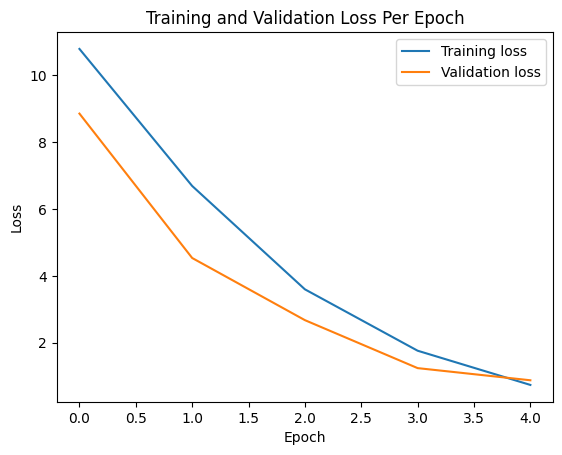

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./trained_bart_faq_generator/tokenizer_config.json',
 './trained_bart_faq_generator/special_tokens_map.json',
 './trained_bart_faq_generator/vocab.json',
 './trained_bart_faq_generator/merges.txt',
 './trained_bart_faq_generator/added_tokens.json')

In [8]:
training_losses = []
validation_losses = []

def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No need to compute gradient when evaluating
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
    return val_loss / len(val_loader)

# Training loop
model.train()
epochs = 5
for epoch in range(epochs):
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = evaluate_model(model, val_loader, device)
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f}")

import matplotlib.pyplot as plt
plt.plot(training_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


model.save_pretrained('./trained_bart_faq_generator')
tokenizer.save_pretrained('./trained_bart_faq_generator')

In [9]:
def Faq_generation(model, tokenizer, context, max_length = 512):
  model.eval()
  inputs = tokenizer(context, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length').to(model.device)
  input_ids = inputs['input_ids'].to(model.device)
  attention_mask = inputs['attention_mask'].to(model.device)

  generated_ids = model.generate(input_ids, attention_mask=attention_mask, max_length=max_length, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)

  generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

  return generated_text

In [10]:
!pip install rouge

In [11]:
generated_faqs = []
for i, row in test_data.iterrows():
    context = row['Admission Text']
    generated_faq = Faq_generation(model, tokenizer, context)
    generated_faqs.append(generated_faq)

reference_faqs = test_data['FAQs'].tolist()

from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(generated_faqs, reference_faqs, avg=True)

print("ROUGE-1:", scores['rouge-1']['f'])  # F1-score of ROUGE-1
print("ROUGE-2:", scores['rouge-2']['f'])  # F1-score of ROUGE-2
print("ROUGE-L:", scores['rouge-l']['f'])  # F1-score of ROUGE-L


ROUGE-1: 0.2654956229375497
ROUGE-2: 0.08365988109840647
ROUGE-L: 0.212230690624009


In [12]:
for i in generated_faqs:
  print(i)

How do I apply? What is the minimum GPA for a Ph.D. in Computer Science? Can I still apply to the program? Do I need to have a master's degree in CS to be considered for admission?
How do I apply to the IMS program? What is the difference between the Graduate School and the School of Engineering? Do I need to have a master’s degree in order to be considered for admission? Is there a minimum GPA requirement? Can I still apply for a Master's degree if I am not enrolled in a graduate program at Vanderbilt University?
What is the difference between the graduate programs at the University of Oklahoma and the U.S. Department of Education? How do I apply? What are my chances of being admitted? Do I need a bachelor’s degree in order to be admitted to the School of Computer Science?
How do I apply to Princeton University? What is the application fee? Do I need to pay a fee to be admitted to the program? Is there a minimum GPA requirement for admission?
How Do I Apply to the Program? What are th